# Workshop 2: Spatial & Geometry Operations on Vector data

Programación SIG  2025-1S    
Universidad Nacional de Colombia    
Alicia Arévalo Robinson

Workshop extracted from [Link](https://github.com/lccastillov/prog_sig_2025_1/blob/main/Workshop6_SpatialOpertaions_Vector_Data.ipynb)

### Modules

In [43]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import contextily as cx
from pathlib import Path
from shapely.geometry import Point

import numpy as np
import shapely
from shapely import affinity

### 1. Data

#### 1.1 Read files path

In [5]:
# Main folder
root_folder = "notebooks/GIS_Programming_Data"

# Path to municipios_colombia.shp
shp_path = root_folder + "/municipios_colombia.shp"
# Read the shapefile using geopandas
muni = gpd.read_file(shp_path).to_crs(epsg=9377)

# Path to Evaluaciones_Agropecuarias_Municipales_EVA.csv
eva_path = root_folder + "/Evaluaciones_Agropecuarias_Municipales_EVA.csv"

# Path to Catalogo_Estaciones_IDEAM.csv"
stations_path = root_folder + "/Catalogo_Estaciones_IDEAM.csv"

# Path to precipitacion.csv"
precip_path = root_folder + "/precipitacion.csv"

#### 1.2 Read CSV files

In [6]:
eva = pd.read_csv(eva_path, encoding='utf-8')
ideam = pd.read_csv(stations_path,encoding='utf-8')  
precip= pd.read_csv(precip_path, encoding='utf-8')

#### 1.3 Organize data

In [7]:
# EVA table, rename code column
eva = (eva.rename(columns={"CÓD. MUN.": "cod_mun"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

#Homogenise municipalities codes
muni["MPIO_CCDGO"] = muni["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]     = eva["cod_mun"].astype(str).str.zfill(5)

print(f"{len(muni):,} municipalities • {len(ideam):,} stations • "
      f"{len(eva):,} EVA rows")

1,122 municipalities • 8,973 stations • 206,068 EVA rows


#### 1.4 Read `ideam` as a `GeoDataGrame`

In [8]:
# Convert string coordinates to Points using string manipulation
ideam['geometry'] = ideam['Ubicación'].apply(
    lambda x: Point(
        float(x.strip('()').split(',')[1]),  # longitude
        float(x.strip('()').split(',')[0])   # latitude
    )
)

# Create GeoDataFrame
ideam_gdf = gpd.GeoDataFrame(
    ideam,
    geometry='geometry',
    crs="EPSG:4326"  # Standard lat/lon coordinates
)

# Reproject to match other layers
ideam_gdf = ideam_gdf.to_crs(9377)
ideam_gdf

,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,POINT (4480921.418 1648261.853)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,POINT (4499992.408 1661153.867)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,POINT (4483759.028 1676727.973)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,POINT (4591897.597 1677940.612)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,POINT (5292824.016 1139928.729)
...,...,...,...,...,...,...,...,...,...,...,...,...
8968,4401700167,NIVEL SANGOYACO GARGANTA,Limnimétrica,Activa,Putumayo,Mocoa,"(1.15872222, -76.67080556)",761,2020-02-25,NaN,Mocoa,POINT (4591496.422 1686336.979)
8969,4401700168,NIVEL MULATO PALMERAS,Limnimétrica,Activa,Putumayo,Mocoa,"(1.15638889, -76.69027778)",966,2020-02-25,NaN,Mocoa,POINT (4589326.12 1686081.462)
8970,4401700172,NIVEL MOCOA PISCIKART,Limnimétrica,Activa,Putumayo,Villagarzón,"(1.03964167, -76.61091944)",408,2020-02-25,NaN,Mocoa,POINT (4598153.817 1673145.302)
8971,4401700173,NIVEL RUMIYACO LAGARTO,Limnimétrica,Activa,Putumayo,Mocoa,"(1.119225, -76.67045)",647,2020-02-25,NaN,Mocoa,POINT (4591530.468 1681964.004)


#### 1.5 Plot `ideam`

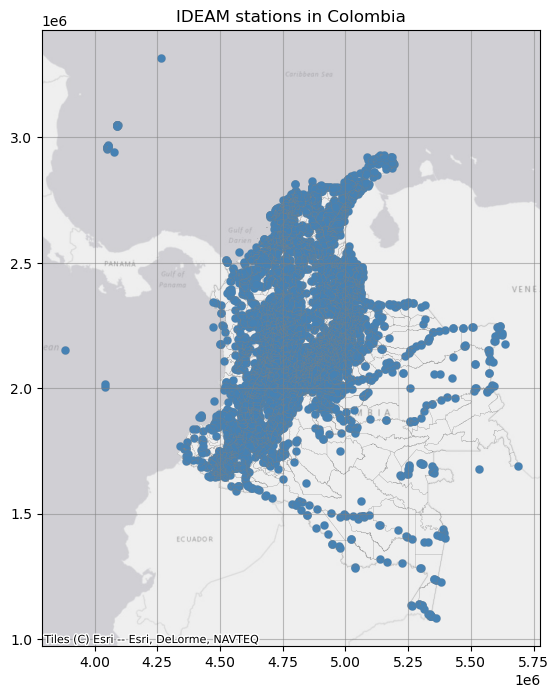

In [9]:
ax = ideam_gdf.plot(
    color='steelblue',
    legend=True,
    figsize=(8, 8),
    edgecolor='grey', linewidth=0.1
)

# Add all municipalities as a background
muni.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.1, zorder=1)

# Add a basemap 
cx.add_basemap(ax, crs=muni.crs,source=cx.providers.Esri.WorldGrayCanvas)

ax.set_title(f'IDEAM stations in Colombia')
#ax.set_axis_off() 
ax.grid(True,color='gray', alpha=0.5) 
plt.show()

#### 1.6 Extract crops names from column **CULTIVO** in `eva`

In [10]:
print(eva["CULTIVO"].unique())
print(eva.columns)

['ACELGA' 'ACHICORIA' 'MALANGA' 'ACHIRA' 'ACHIOTE' 'AGRAZ' 'AGUACATE'
 'AJI' 'AGUAJE' 'AHUYAMA' 'AJO' 'AJONJOLI' 'ALBAHACA' 'ALFALFA'
 'ALCACHOFA' 'ALGARROBO' 'ALGODON' 'AMARANTO' 'ANIS' 'ANON' 'ANTURIO'
 'APIO' 'ARANDANO' 'ARAZA' 'ARRACACHA' 'ARROZ' 'ARVEJA' 'ASAI'
 'ASPARRAGUS' 'ASTROMELIA' 'AVENA' 'BACURI' 'BADEA' 'BANANITO' 'BANANO'
 'BATATA' 'BERENJENA' 'BREVO' 'BORE' 'BOROJO' 'BROCOLI' 'CACAO' 'PLATANO'
 'CADUCIFOLIOS' 'CAFE' 'CAUCHO' 'CAIMO' 'CALABACIN' 'CALABAZA' 'CALENDULA'
 'CANYARANA' 'CAÑA AZUCARERA' 'CAÑA FLECHA' 'CAÑA MIEL' 'CAÑA PANELERA'
 'CARDAMOMO' 'CEBADA' 'CEBOLLA DE BULBO' 'CENTENO' 'CEBOLLA DE RAMA'
 'CEBOLLIN' 'CHACHAFRUTO' 'CHAMBA' 'CHAMPIÑON' 'CHIA' 'CIMARRON'
 'CHIRIMOYA' 'CHOLUPA' 'CIRUELA' 'CHONQUE' 'CHONTADURO' 'CITRICOS'
 'CILANTRO' 'CLAVEL' 'COCCULUS' 'COCO' 'COCONA' 'COL' 'CURUBA' 'COLIFLOR'
 'COPOAZU' 'CORDELINE CINTA' 'COROZO' 'CURCUMA' 'DATIL' 'DURAZNO' 'ENELDO'
 'ESPARRAGO' 'ESPARTO' 'ESPINACA' 'ESTROPAJO' 'EUCALIPTO BABY BLUE'
 'FEIJOA' 'FIQUE' 'FIT

### 2. Spatial operations on vector data

#### 2.1 Spatial subsetting

Identify IDEAM stations within Bogotá D.C  
- Select `ideam_gdf` points that intersects with Bogotá polygon (`bogota_muni`) 

In [11]:
bogota_muni = muni[muni["MPIO_CNMBR"].str.upper().str.contains("BOGOTÁ")].copy()

bta_stations_bool = ideam_gdf.intersects(bogota_muni.geometry.iloc[0])
bta_stations_bool

0       False
1       False
2       False
3       False
4       False
        ...  
8968    False
8969    False
8970    False
8971    False
8972    False
Length: 8973, dtype: bool

- Subset the stations using the obtained Boolean Series

In [12]:
bogota_stations = ideam_gdf[bta_stations_bool]
print(bogota_stations)

          Codigo                                          Nombre  \
92      21206920                   VILLA TERESA - AUT [21206920]   
124     21206960                  IDEAM BOGOTA  - AUT [21206960]   
125     21205012          UNIVERSIDAD NACIONAL  - AUT [21205012]   
303   2120500127           RADIO SONDA BOGOTA - AUT [2120500127]   
318     21206570                     AEROPUERTO CATAM [21206570]   
...          ...                                             ...   
8952  2120000141    COLEGIO VEINTIUN ANGELES - AUT  [2120000099]   
8953  2120000144  COLEGIO ALEMANIA SOLIDARIA - AUT  [2120000100]   
8955  2120000149      COLEGIO RODOLFO LLINAS - AUT  [2120000109]   
8956  2120000150                 GRAN BRETAÑA - AUT [2120000106]   
8957  2120000151                         LA FISCALA [2120000107]   

                Categoria      Estado Departamento    Municipio  \
92    Climática Principal      Activa       Bogotá  Bogota, D.C   
124   Climática Principal      Activa       Bogot

#### 2.2 Display the stations over the boundaries of Bogota

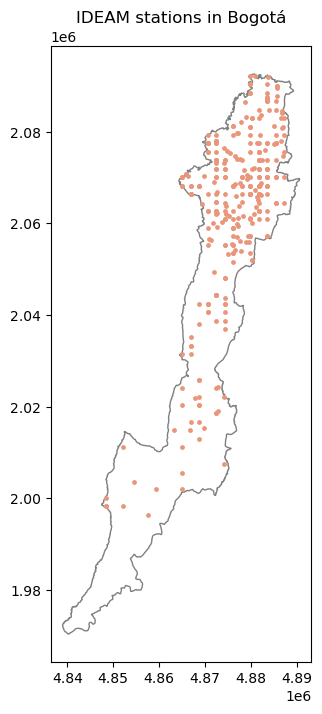

In [13]:
ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bogota_stations.plot(ax=ax, color="darksalmon", markersize=6)
plt.title("IDEAM stations in Bogotá")
plt.show()

Display the results in the within the country

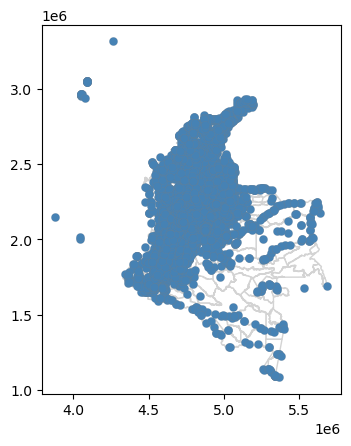

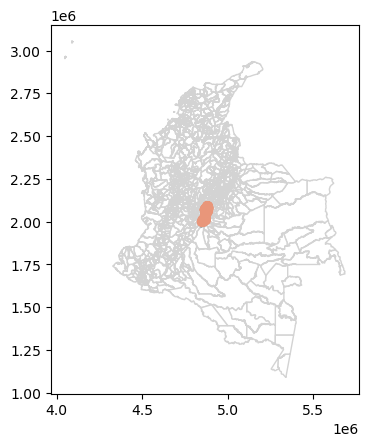

In [14]:
# Original
base = muni.plot(color='white', edgecolor='lightgrey')
ideam_gdf.plot(ax=base, color='steelblue', edgecolor='grey', linewidth=0.1);

# Subset (intersects)
base = muni.plot(color='white', edgecolor='lightgrey')
bogota_muni.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
bogota_stations.plot(ax=base, color='None', edgecolor='darksalmon');

#### Other topological relations

In [18]:
cumaribo_muni = muni[muni["MPIO_CNMBR"].str.upper().str.contains("CUMARIBO")].copy()

cumaribo_muni_bool_disj = ideam_gdf.disjoint(cumaribo_muni.geometry.iloc[0])
cumaribo_muni_bool_disj # Display the boolean dataset
non_cumaribo_stations = ideam_gdf[cumaribo_muni_bool_disj ]

Plot

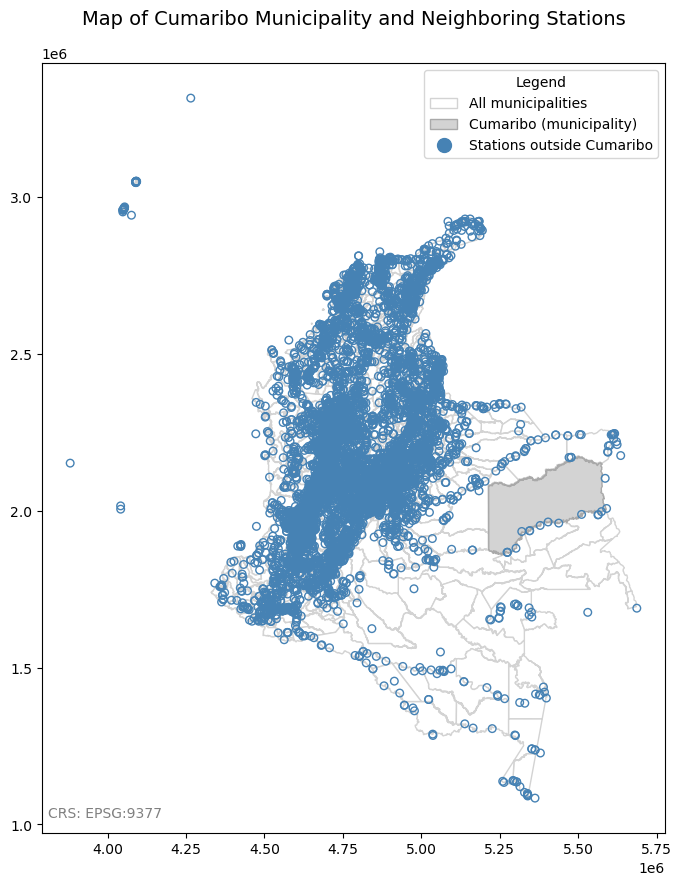

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

# 1. Base layer: all municipalities
muni.plot(
    ax=ax,
    color='white',
    edgecolor='lightgrey'
)

# 2. Highlight Cumaribo municipality
cumaribo_muni.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='darkgrey'
)

# 3. Plot stations not in Cumaribo
non_cumaribo_stations.plot(
    ax=ax,
    color='None',
    edgecolor='steelblue',
    marker='o',
    markersize=30
)

# 4. Title
ax.set_title(
    "Map of Cumaribo Municipality and Neighboring Stations\n",
    fontsize=14,
    pad=12
)

# 5. Create proxy artists for the legend
#    - Patch for “All municipalities” (white fill, lightgrey edge)
patch_allmun = mpatches.Patch(
    facecolor='white',
    edgecolor='lightgrey',
    label='All municipalities'
)

#    - Patch for “Cumaribo” (lightgrey fill, darkgrey edge)
patch_cumaribo = mpatches.Patch(
    facecolor='lightgrey',
    edgecolor='darkgrey',
    label='Cumaribo (municipality)'
)

#    - Line2D for “Stations outside Cumaribo” (red circle marker)
marker_stations = mlines.Line2D(
    [], [], 
    color='steelblue',   # edgecolor of the marker
    marker='o',
    linestyle='None',
    markersize=10,
    label='Stations outside Cumaribo'
)

# 6. Add the legend using those proxy handles
ax.legend(
    handles=[patch_allmun, patch_cumaribo, marker_stations],
    loc='upper right',
    title='Legend',
    frameon=True
)

# 7. Annotate CRS info in the bottom-left corner
crs_text = f"CRS: {muni.crs.to_string()}"
ax.text(
    0.01, 0.02, crs_text,
    transform=ax.transAxes,
    fontsize=10,
    color='grey',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2)
)

plt.show()

👩‍💻 **Now it’s your turn # 1**  

For a variation on the previous spatial subsetting exercise, pick a department of your choice and:

Dissolve all its municipality polygons into a single department-level geometry.
Subset the IDEAM station GeoDataFrame to keep only those points that intersect your department polygon.

**Deliverables**  

1. A small table listing the station IDs and names you selected.  
2. A map showing your dissolved department boundary (in grey) with the intersecting stations overlaid (in a contrasting colour).

### Topological stations

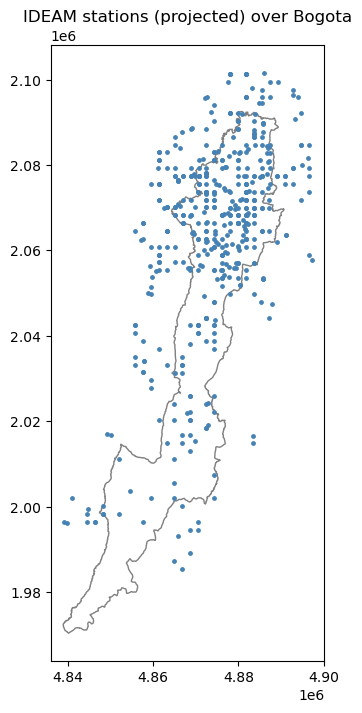

In [24]:
#points.distance(poly.iloc[0]) < 0.2

bta__10km_stations_bool = ideam_gdf.distance(bogota_muni.geometry.iloc[0])<10000
bta__10km_stations_bool # Display the boolean dataset
bta_10km_stations=ideam_gdf[bta__10km_stations_bool]

ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bta_10km_stations.plot(ax=ax, color="steelblue", markersize=6)
plt.title("IDEAM stations (projected) over Bogota")
plt.show()

**👩‍💻 Now it’s your turn # 2.**  

Use the Bogotá polygon (bogota_muni) to identify all IDEAM stations that lie outside the city boundary but within a 20 km buffer around it. In other words, you need to:

1. Compute the distance from each station point in gdf_est to the Bogotá polygon.
2. List all the stations found and show their altitude
3. Plot the stations in a map

### Spatial joining

Overlapping joins

In [26]:
# 1. Spatial join: each station takes the attributes of the municipality it falls in
stations_with_mun = gpd.sjoin(
    ideam_gdf,                     # left: point layer
    muni[["MPIO_CCDGO", "MPIO_CNMBR","MPIO_CCDGO", "geometry"]],  # right: polygon layer
    how="left",
    predicate="within"           # point inside polygon
)

# 2. Inspect the result
stations_with_mun[["Codigo", "MPIO_CNMBR", "MPIO_CCDGO"]].head()

,Codigo,MPIO_CNMBR,MPIO_CCDGO,MPIO_CCDGO
0,52057100,IPIALES,00356,00356
1,52055170,CONTADERO,00210,00210
2,52055220,TÚQUERRES,00838,00838
3,44015070,MOCOA,00001,00001
4,48015040,PUERTO NARIÑO,00540,00540


Non overlapping joins

       Codigo                                  Nombre            Categoria  \
78   21195170                PAQUILO - AUT [21195170]  Climática Principal   
91   21195190                  PASCA - AUT [21195190]    Agrometeorológica   
92   21206920           VILLA TERESA - AUT [21206920]  Climática Principal   
107  21206990              TIBAITATA - AUT [21206990]    Agrometeorológica   
112  21206980  SANTA CRUZ DE SIECHA  - AUT [21206980]    Agrometeorológica   

     Estado  Departamento                Municipio  \
78   Activa  Cundinamarca   Cabrera (Cundinamarca)   
91   Activa  Cundinamarca                    Pasca   
92   Activa        Bogotá              Bogota, D.C   
107  Activa  Cundinamarca  Mosquera (Cundinamarca)   
112  Activa  Cundinamarca                   Guasca   

                      Ubicación  Altitud Fecha_instalacion Fecha_suspension  \
78   (3.99361111, -74.39805556)     2957        2005-07-23              NaN   
91      (4.31011111, -74.31175)     2256        

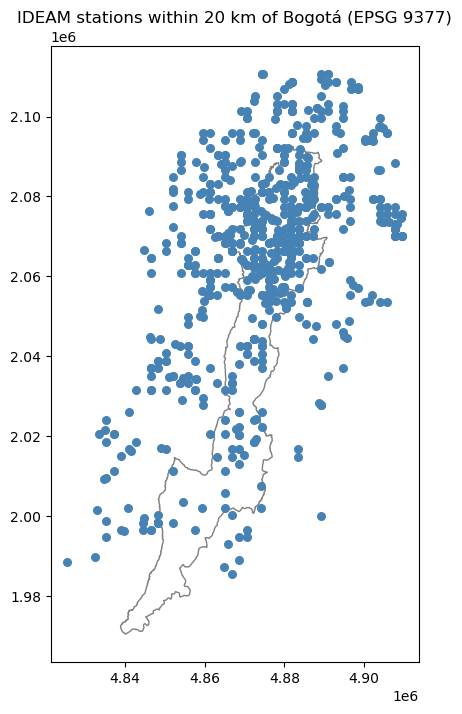

In [29]:
# 1. Create a 20 km buffer around Bogotá
bogota_muni_buffer = bogota_muni.copy()
bogota_muni_buffer["geometry_20km"] = bogota_muni_buffer.geometry.buffer(20000)
bogota_muni_buffer = bogota_muni_buffer.set_geometry("geometry_20km")

# 2. Spatial join – keep only stations that intersect the buffer
bogota_buffer_20k_stations = gpd.sjoin(
    ideam_gdf,                 # left: station points
    bogota_muni_buffer,     # right: buffer polygons
    how='inner',            # keep only points that intersect the buffer
    predicate='intersects'  # or 'within'
)

# 3. View result
print(bogota_buffer_20k_stations.head())

# 4. Plot Bogotá and the selected stations
ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bogota_buffer_20k_stations.plot(ax=ax, color="steelblue", markersize=30)
plt.title("IDEAM stations within 20 km of Bogotá (EPSG 9377)")
plt.show()

Joining incongruent layers

In [32]:
# Create a regular grid covering Colombia

# Bounds of the municipalities layer
bounds = muni.total_bounds
xmin, ymin, xmax, ymax = bounds

# Define grid resolution (example: 100 km x 100 km grid → 100_000 m)
res = 100000

# Build grid coordinates
cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax + res)), res))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax + res)), res))
rows.reverse()

# Build polygons for each grid cell
polygons = []
for x in cols:
    for y in rows:
        polygons.append(
            shapely.Polygon([
                (x, y),
                (x + res, y),
                (x + res, y - res),
                (x, y - res)
            ])
        )

# Create grid GeoDataFrame
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=muni.crs)

# Remove cells that fall outside the total extent (intersect municipalities only)
sel = grid.intersects(shapely.box(*bounds))
grid = grid[sel]

# Add unique ID
grid['id'] = grid.index

grid.head()

,geometry,id
0,"POLYGON ((4047822 3090086, 4147822 3090086, 41...",0
1,"POLYGON ((4047822 2990086, 4147822 2990086, 41...",1
2,"POLYGON ((4047822 2890086, 4147822 2890086, 41...",2
3,"POLYGON ((4047822 2790086, 4147822 2790086, 41...",3
4,"POLYGON ((4047822 2690086, 4147822 2690086, 41...",4


Now we have a regular grid of squares covering the extent of Colombia.  

Next, we will perform an overlay operation to split the municipality polygons according to the grid cells, and then transfer a polygon attribute (e.g. population or area) to the grid cells.

In [33]:
#  Prepare the municipalities layer: add 'area' attribute

# Calculate polygon area in square metres
muni['area_m2'] = muni.area

# Example variable to transfer: let's simulate that each municipality has an attribute 'population'
# For this example only: we'll assign a dummy population proportional to area (you can replace it with real data)
muni['population'] = muni['area_m2'] / 1e6  # arbitrary example: 1 person per km²

# View sample
muni[['MPIO_CNMBR', 'area_m2', 'population']].head()

,MPIO_CNMBR,area_m2,population
0,FLORENCIA,2.546958e+09,2546.958298
1,ALBANIA,4.141007e+08,414.100691
2,BELÉN DE LOS ANDAQUÍES,1.191551e+09,1191.551389
3,EL DONCELLO,1.105515e+09,1105.514836
4,EL PAUJÍL,1.234141e+09,1234.140645


Overlay operation: split municipalities by grid cells

In [ ]:
mun_grid = muni.overlay(grid)

# Keep only needed columns
mun_grid = mun_grid[['id', 'area_m2', 'population', 'geometry']]

# Compute the area of each piece (intersection area)
mun_grid['area_sub'] = mun_grid.area

mun_grid.head()

,id,area_m2,population,geometry,area_sub
0,138,2.546958e+09,2546.958298,"POLYGON ((4730891.264 1800687.527, 4730982.048...",8.540306e+07
1,139,2.546958e+09,2546.958298,"POLYGON ((4733986.939 1790054.988, 4733960.326...",2.461555e+09
2,139,4.141007e+08,414.100691,"POLYGON ((4677934.064 1709133.8, 4677934.101 1...",2.824512e+08
3,140,4.141007e+08,414.100691,"POLYGON ((4693057.163 1690081.8, 4693088.62 16...",1.316495e+08
4,139,1.191551e+09,1191.551389,"POLYGON ((4690005.125 1751582.406, 4689993.69 ...",1.190663e+09


Plot

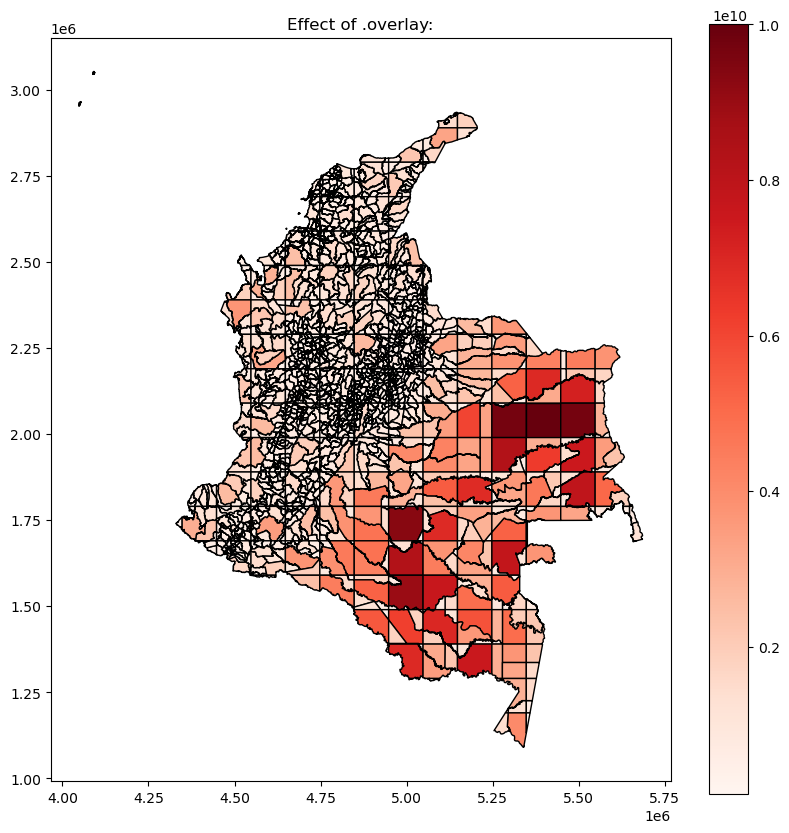

In [36]:
ax = mun_grid.plot(
    column='area_sub',
    edgecolor='black',
    legend=True,
    cmap='Reds',
    figsize=(10, 10),
    vmin=100000000,
    vmax=10000000000
)

plt.title("Effect of .overlay:")
plt.show()

At this stage, each grid cell contains **pieces of municipality polygons**.  
But the *Population* field still holds the original full polygon value — we need to adjust it.  

Next we compute the **area proportion** and the corrected population per piece.

In [37]:
# Compute area proportion and corrected population per piece

mun_grid['area_prop'] = mun_grid['area_sub'] / mun_grid['area_m2']
mun_grid['population_part'] = mun_grid['population'] * mun_grid['area_prop']

mun_grid[['id', 'area_prop', 'population_part']].head()

,id,area_prop,population_part
0,138,0.033531,85.403059
1,139,0.966469,2461.555239
2,139,0.682083,282.451200
3,140,0.317917,131.649491
4,139,0.999254,1190.663037


Finally, we aggregate the contributions per grid cell:  
sum the **population of all pieces** belonging to each grid cell.

In [38]:
# Aggregate to grid

# Sum the partial populations per grid cell
grid_population = mun_grid.groupby('id')['population_part'].sum().reset_index()

# Join the result back to the grid
grid = pd.merge(grid, grid_population, on='id', how='left')

                                              geometry   id  population_part
213  POLYGON ((5047822 1790086, 5147822 1790086, 51...  223          10000.0
193  POLYGON ((4947822 1790086, 5047822 1790086, 50...  202          10000.0
107  POLYGON ((4547822 2390086, 4647822 2390086, 46...  112          10000.0
272  POLYGON ((5347822 1890086, 5447822 1890086, 54...  285          10000.0
252  POLYGON ((5247822 1890086, 5347822 1890086, 53...  264          10000.0
..                                                 ...  ...              ...
335  POLYGON ((5647822 1590086, 5747822 1590086, 57...  351              NaN
336  POLYGON ((5647822 1490086, 5747822 1490086, 57...  352              NaN
337  POLYGON ((5647822 1390086, 5747822 1390086, 57...  353              NaN
338  POLYGON ((5647822 1290086, 5747822 1290086, 57...  354              NaN
339  POLYGON ((5647822 1190086, 5747822 1190086, 57...  355              NaN

[340 rows x 3 columns]


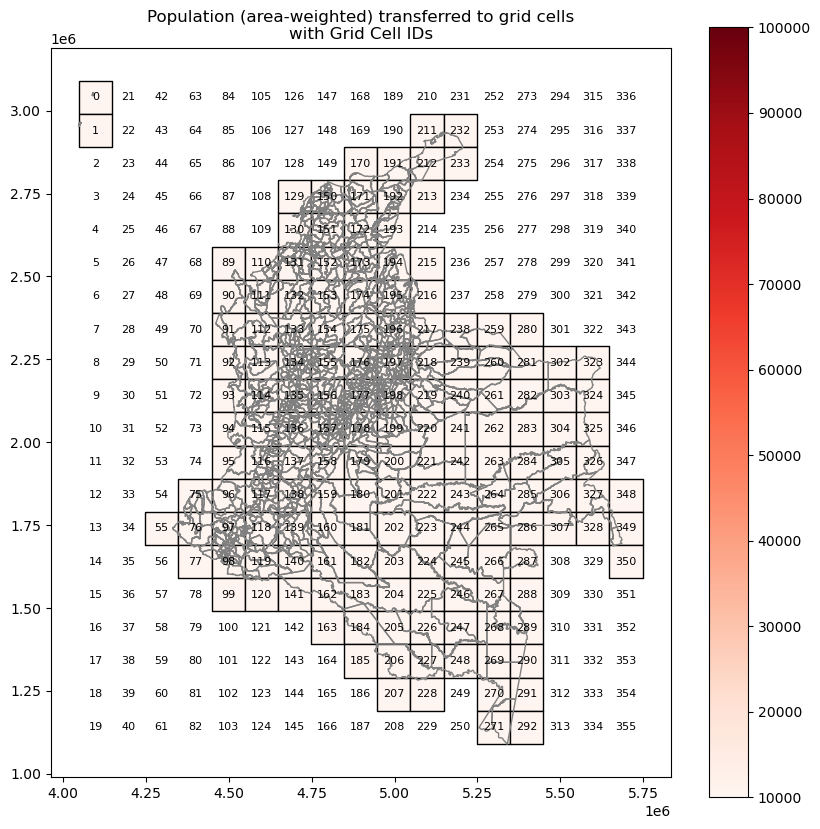

In [51]:
# Plot the result
print(grid.sort_values(by=['population_part'],ascending=False))
ax = grid.plot(
    column='population_part',
    edgecolor='black',
    legend=True,
    cmap='Reds',
    figsize=(10, 10),
    vmin=10000,
    vmax=100000
)

# Overlay the municipality boundaries
muni.plot(ax=ax, color='none', edgecolor='grey')

# Add ID labels at centroid of each grid cell
for idx, row in grid.iterrows():
    # Compute centroid of the polygon
    centroid = row['geometry'].centroid
    # Draw text label at the centroid coordinates
    ax.text(
        centroid.x, centroid.y, 
        str(row['id']), 
        ha='center', va='center', 
        fontsize=8, color='black'
    )

# Title
plt.title("Population (area-weighted) transferred to grid cells\nwith Grid Cell IDs")
plt.show()

### 3. Geometry operations on vector data

#### Simplification

In [ ]:
# Simplify a municipality boundary with Douglas–Peucker 500 m tolerance
poly = muni.iloc[0].geometry
simple = poly.simplify(500)

gpd.GeoSeries({'Original': poly, 'Simplified': simple}).plot(alpha=0.5, edgecolor=['black','red'])
plt.title('Boundary simplification (500 m tolerance)')
plt.show()

#### Centroids

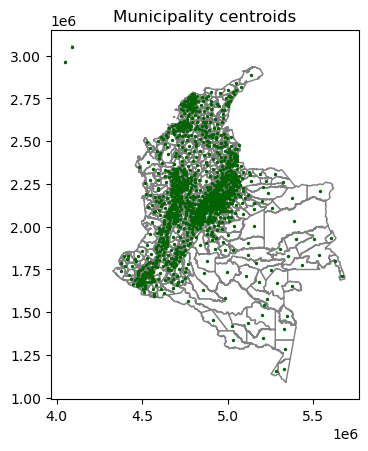

In [40]:
muni['centroid'] = muni.centroid
ax = muni.plot(color='white', edgecolor='grey')
muni.set_geometry('centroid').plot(ax=ax, color='darkgreen', markersize=2)
plt.title('Municipality centroids')
plt.show()

#### Buffers

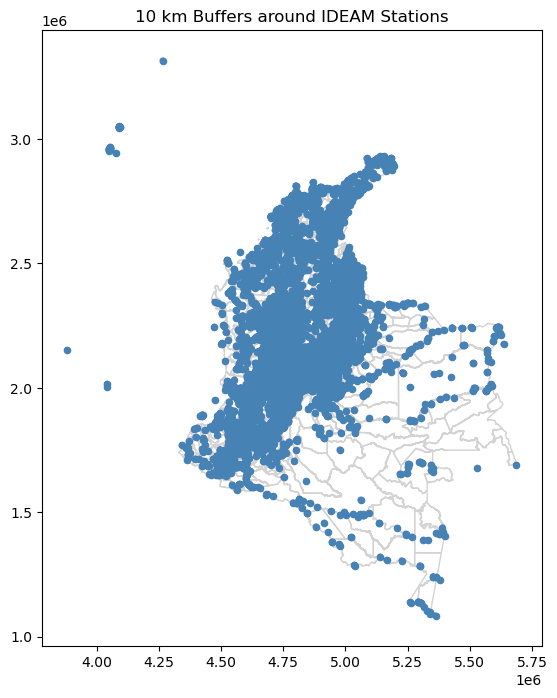

In [41]:
# Create a 10 km buffer around each station
ideam_gdf['buffer_10km'] = ideam_gdf.geometry.buffer(10000)

# Visualise one example station buffer
ax = muni.plot(color='none', edgecolor='lightgrey', figsize=(8, 8))
gpd.GeoSeries(ideam_gdf['buffer_10km']).plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)
ideam_gdf.plot(ax=ax, color='steelblue', markersize=20)

plt.title("10 km Buffers around IDEAM Stations")
plt.show()

**👩‍💻 Now it’s your turn # 3**.

You will now apply what you learned about buffer creation using a real-world vector dataset:  

👉 Download the roads vector layer from INVIAS Open Data Portal:  
https://inviasopendata-invias.opendata.arcgis.com/  

You can download, for example, the dataset called "**Red Vial Nacional**" or "**Inventario de Vías**".  

1. Import the vector layer (e.g. roads_invias.shp) into your notebook using gpd.read_file().
2. Create a 1 km buffer around all road geometries.
3. Plot both the roads and the buffer on a single map (use different colours and transparency).

#### Geometry unions

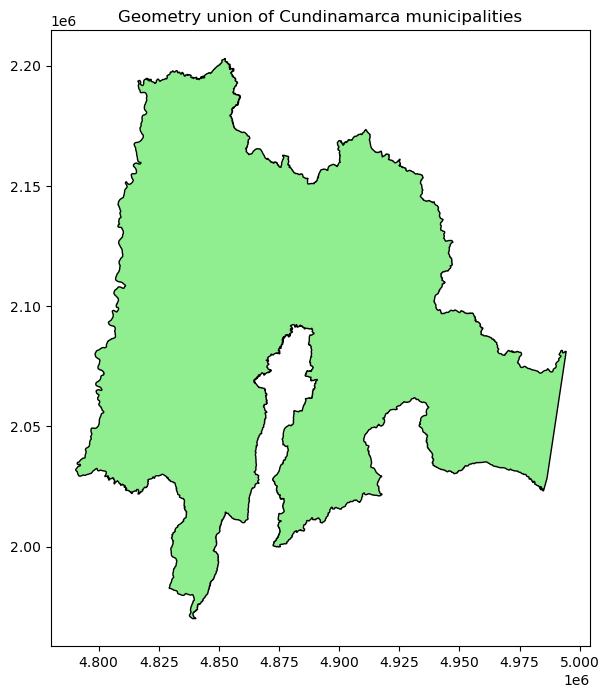

In [42]:
# Union of all Cundinamarca municipalities
cundi_union = muni[muni["DPTO_CCDGO"] == "25"].geometry.union_all()

# Plot
gpd.GeoSeries([cundi_union]).plot(color='lightgreen', edgecolor='black', figsize=(8, 8))

plt.title("Geometry union of Cundinamarca municipalities")
plt.show()

**👩‍💻 Now it’s your turn # 4.**  

Create the union of all municipalities that produce Maíz.  
Plot the result and compare it to the individual municipal geometries.

#### Affine transformations

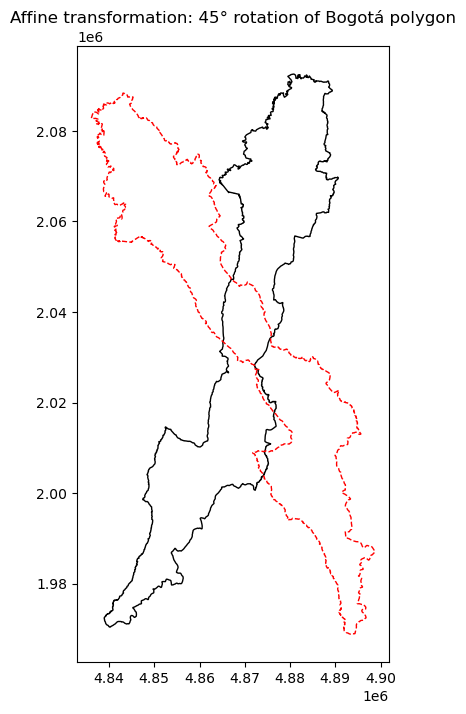

In [44]:
# Select one municipality polygon (Bogotá)
bogota_geom = bogota_muni.geometry.iloc[0]

# Apply a 45 degree rotation around its centroid
bogota_rotated = affinity.rotate(bogota_geom, 45, origin='centroid')

# Plot original and rotated polygon
ax = gpd.GeoSeries([bogota_geom]).plot(color='none', edgecolor='black', figsize=(8, 8), label='Original')
gpd.GeoSeries([bogota_rotated]).plot(ax=ax, color='none', edgecolor='red', linestyle='--', label='Rotated')

plt.title("Affine transformation: 45° rotation of Bogotá polygon")
plt.show()

**👩‍💻 Now it’s your turn # 5.**  

Select a municipality of your choice and:  

1. Apply a scaling transformation to enlarge it by 1.5x in X and 0.8x in Y.
2. Plot the original and transformed polygon for comparison.

#### Pairwise geometry-generating operations

Example: intersection between Bogotá buffer and Cundinamarca  

Let’s see which part of the Bogotá 20 km buffer overlaps Cundinamarca.

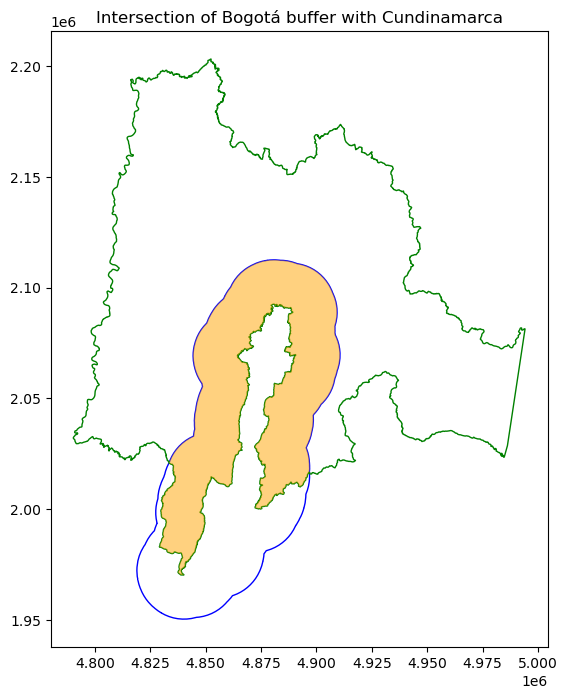

In [45]:
# Cundinamarca polygon
cundi_geom = muni[muni["DPTO_CCDGO"] == "25"].dissolve().geometry.iloc[0]

# 20 km buffer around Bogotá
bogota_20km_buffer = bogota_geom.buffer(20000)

# Intersection of buffer and Cundinamarca
buffer_cundi_intersection = bogota_20km_buffer.intersection(cundi_geom)

# Plot result
ax = gpd.GeoSeries([bogota_20km_buffer]).plot(color='none', edgecolor='blue', figsize=(8, 8), label='Bogotá buffer')
gpd.GeoSeries([cundi_geom]).plot(ax=ax, color='none', edgecolor='green', label='Cundinamarca')
gpd.GeoSeries([buffer_cundi_intersection]).plot(ax=ax, color='orange', alpha=0.5, label='Intersection')

plt.title("Intersection of Bogotá buffer with Cundinamarca")
plt.show()

#### Subsetting and Clipping

Example: clip the station buffers using the Bogotá polygon.

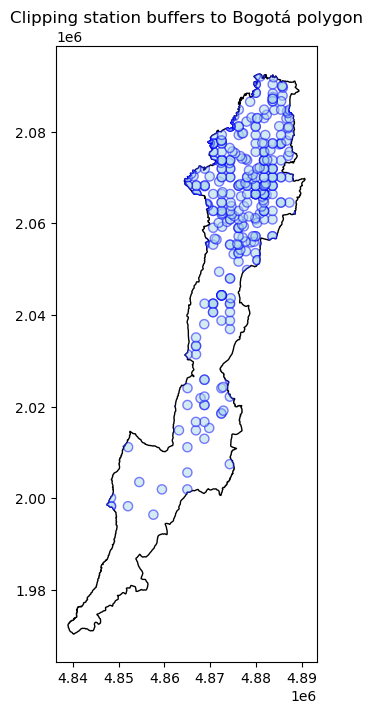

In [ ]:
# Clip 10 km station buffers with Bogotá boundary

# First select station buffers intersecting Bogotá
station_buffers = ideam_gdf.copy()
station_buffers['buffer_5km'] = station_buffers.geometry.buffer(1000)

# Clip buffers with Bogotá polygon
station_buffers_clipped = gpd.clip(station_buffers.set_geometry('buffer_5km'), bogota_geom)

# Plot
ax = gpd.GeoSeries([bogota_geom]).plot(color='none', edgecolor='black', figsize=(8, 8), label='Bogotá')
station_buffers_clipped.plot(ax=ax, facecolor='lightblue', edgecolor='blue', alpha=0.5)

plt.title("Clipping station buffers to Bogotá polygon")
plt.show()

Calcular donde poner una estación de precipitacion del ideam en cravo norte que quede cerca a una via